# Summary

#### Kaggle dataset - https://www.kaggle.com/spscientist/students-performance-in-exams

In this code, we are trying to find the best model fit using H2O AutoML and it gives the best model fit by the leaderboard. The data was run for different time durrations - 100, 500, 1000 seconds. THe metrices accured are as below:

100 seconds:

	model_id	mean_residual_deviance	rmse	mse	mae	rmsle
0	GLM_grid_1_AutoML_20181214_170410_model_1	29.02784389	5.387749427	29.02784389	4.297588518	0.107228305
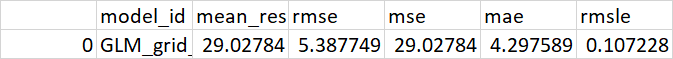

500 seconds:

0	GLM_grid_1_AutoML_20181214_164649_model_1	29.02784389	5.387749427	29.02784389	4.297588518	0.107228305


1000 seconds:

0	GLM_grid_1_AutoML_20181214_163049_model_1	29.02784389	5.387749427	29.02784389	4.297588518	0.107228305


As seen, for all the time taken, GBM is the best algorithm in the leaderboard and has the same rmse values compared.

In [1]:
import h2o
from h2o.automl import H2OAutoML
import random, os, sys
from datetime import datetime
import pandas as pd
import logging
import csv
import optparse
import time
import json
from distutils.util import strtobool
import psutil

In [2]:
data_path=None
all_variables=None
test_path=None
# target='search_term'
target=None
nthreads=1 
min_mem_size=6 
run_time=1000
classification=False
scale=False
max_models=9    
model_path=None
balance_y=False 
balance_threshold=0.2
name=None 
server_path=None  
analysis=0 

In [3]:
pct_memory=0.5
virtual_memory=psutil.virtual_memory()
min_mem_size=int(round(int(pct_memory*virtual_memory.available)/1073741824,0))
print(min_mem_size)

5


In [4]:
# Functions

def alphabet(n):
  alpha='0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'    
  str=''
  r=len(alpha)-1   
  while len(str)<n:
    i=random.randint(0,r)
    str+=alpha[i]   
  return str
  
  
def set_meta_data(analysis,run_id,server,data,test,model_path,target,run_time,classification,scale,model,balance,balance_threshold,name,path,nthreads,min_mem_size):
  m_data={}
  m_data['start_time'] = time.time()
  m_data['target']=target
  m_data['server_path']=server
  m_data['data_path']=data 
  m_data['test_path']=test
  m_data['max_models']=model
  m_data['run_time']=run_time
  m_data['run_id'] =run_id
  m_data['scale']=scale
  m_data['classification']=classification
  m_data['scale']=False
  m_data['model_path']=model_path
  m_data['balance']=balance
  m_data['balance_threshold']=balance_threshold
  m_data['project'] =name
  m_data['end_time'] = time.time()
  m_data['execution_time'] = 0.0
  m_data['run_path'] =path
  m_data['nthreads'] = nthreads
  m_data['min_mem_size'] = min_mem_size
  m_data['analysis'] = analysis
  return m_data


def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()
  
  
def stackedensemble(mod):
    coef_norm=None
    try:
      metalearner = h2o.get_model(mod.metalearner()['name'])
      coef_norm=metalearner.coef_norm()
    except:
      pass        
    return coef_norm

def stackedensemble_df(df):
    bm_algo={ 'GBM': None,'GLM': None,'DRF': None,'XRT': None,'Dee': None}
    for index, row in df.iterrows():
      if len(row['model_id'])>3:
        key=row['model_id'][0:3]
        if key in bm_algo:
          if bm_algo[key] is None:
                bm_algo[key]=row['model_id']
    bm=list(bm_algo.values()) 
    bm=list(filter(None.__ne__, bm))             
    return bm

def se_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['auc']=modl.auc()   
    d['roc']=modl.roc()
    d['mse']=modl.mse()   
    d['null_degrees_of_freedom']=modl.null_degrees_of_freedom()
    d['null_deviance']=modl.null_deviance()
    d['residual_degrees_of_freedom']=modl.residual_degrees_of_freedom()   
    d['residual_deviance']=modl.residual_deviance()
    d['rmse']=modl.rmse()
    return d

def get_model_by_algo(algo,models_dict):
    mod=None
    mod_id=None    
    for m in list(models_dict.keys()):
        if m[0:3]==algo:
            mod_id=m
            mod=h2o.get_model(m)      
    return mod,mod_id     
    
    
def gbm_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    return d
    
    
def dl_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    return d
    
    
def drf_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    d['roc']=modl.roc()      
    return d
    
def xrt_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    d['roc']=modl.roc()      
    return d
    
    
def glm_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['coef']=modl.coef()  
    d['coef_norm']=modl.coef_norm()      
    return d
    
def model_performance_stats(perf):
    d={}
    try:    
      d['mse']=perf.mse()
    except:
      pass      
    try:    
      d['rmse']=perf.rmse() 
    except:
      pass      
    try:    
      d['null_degrees_of_freedom']=perf.null_degrees_of_freedom()
    except:
      pass      
    try:    
      d['residual_degrees_of_freedom']=perf.residual_degrees_of_freedom()
    except:
      pass      
    try:    
      d['residual_deviance']=perf.residual_deviance() 
    except:
      pass      
    try:    
      d['null_deviance']=perf.null_deviance() 
    except:
      pass      
    try:    
      d['aic']=perf.aic() 
    except:
      pass      
    try:
      d['logloss']=perf.logloss() 
    except:
      pass    
    try:
      d['auc']=perf.auc()
    except:
      pass  
    try:
      d['gini']=perf.gini()
    except:
      pass    
    return d
    
def impute_missing_values(df, x, scal=False):
    # determine column types
    ints, reals, enums = [], [], []
    for key, val in df.types.items():
        if key in x:
            if val == 'enum':
                enums.append(key)
            elif val == 'int':
                ints.append(key)            
            else: 
                reals.append(key)    
    _ = df[reals].impute(method='mean')
    _ = df[ints].impute(method='median')
    if scal:
        df[reals] = df[reals].scale()
        df[ints] = df[ints].scale()    
    return


def get_independent_variables(df, targ):
    C = [name for name in df.columns if name != targ]
    # determine column types
    ints, reals, enums = [], [], []
    for key, val in df.types.items():
        if key in C:
            if val == 'enum':
                enums.append(key)
            elif val == 'int':
                ints.append(key)            
            else: 
                reals.append(key)    
    x=ints+enums+reals
    return x
    
def get_all_variables_csv(i):
    ivd={}
    try:
      iv = pd.read_csv(i,header=None)
    except:
      sys.exit(1)    
    col=iv.values.tolist()[0]
    dt=iv.values.tolist()[1]
    i=0
    for c in col:
      ivd[c.strip()]=dt[i].strip()
      i+=1        
    return ivd
    
    

def check_all_variables(df,dct,y=None):     
    targ=list(dct.keys())     
    for key, val in df.types.items():
        if key in targ:
          if dct[key] not in ['real','int','enum']:                      
            targ.remove(key)  
    for key, val in df.types.items():
        if key in targ:            
          if dct[key] != val:
            print('convert ',key,' ',dct[key],' ',val)
            if dct[key]=='enum':
                try:
                  df[key] = df[key].asfactor() 
                except:
                  targ.remove(key)                 
            if dct[key]=='int': 
                try:                
                  df[key] = df[key].asnumeric() 
                except:
                  targ.remove(key)                  
            if dct[key]=='real':
                try:                
                  df[key] = df[key].asnumeric()  
                except:
                  targ.remove(key)                  
    if y is None:
      y=df.columns[-1] 
    if y in targ:
      targ.remove(y)
    else:
      y=targ.pop()            
    return targ    
    
def predictions(mod,data,run_id):
    test = h2o.import_file(data)
    mod_perf=mod_best.model_performance(test)
              
    stats_test={}
    stats_test=model_performance_stats(mod_perf)

    n=run_id+'_test_stats.json'
    dict_to_json(stats_test,n) 

    try:    
      cf=mod_perf.confusion_matrix(metrics=["f1","f2","f0point5","accuracy","precision","recall","specificity","absolute_mcc","min_per_class_accuracy","mean_per_class_accuracy"])
      cf_df=cf[0].table.as_data_frame()
      cf_df.to_csv(run_id+'_test_confusion_matrix.csv')
    except:
      pass

    predictions = mod_best.predict(test)
    predictions_df=test.cbind(predictions).as_data_frame() 
    predictions_df.to_csv(run_id+'_predictions.csv')
    return

def predictions_test(mod,test,run_id):
    mod_perf=mod_best.model_performance(test)          
    stats_test={}
    stats_test=model_performance_stats(mod_perf)
    n=run_id+'_test_stats.json'
    dict_to_json(stats_test,n) 
    try:
      cf=mod_perf.confusion_matrix()
#      cf=mod_perf.confusion_matrix(metrics=["f1","f2","f0point5","accuracy","precision","recall","specificity","absolute_mcc","min_per_class_accuracy","mean_per_class_accuracy"])
      cf_df=cf.table.as_data_frame()
      cf_df.to_csv(run_id+'_test_confusion_matrix.csv')
    except:
      pass
    predictions = mod_best.predict(test)    
    predictions_df=test.cbind(predictions).as_data_frame() 
    predictions_df.to_csv(run_id+'_predictions.csv')
    return predictions

def check_X(x,df):
    for name in x:
        if name not in df.columns:
          x.remove(name)  
    return x    
    
    
def get_stacked_ensemble(lst):
    se=None
    for model in model_set:
      if 'BestOfFamily' in model:
        se=model
    if se is None:     
      for model in model_set:
        if 'AllModels'in model:
          se=model           
    return se       
    
def get_variables_types(df):
    d={}
    for key, val in df.types.items():
        d[key]=val           
    return d    
    
#  End Functions

In [5]:
all_variables=None

In [17]:
data_path='C:/Users/prabh/Desktop/ML/Project ML/Dataset/StudentsPerformance.csv'

In [18]:
run_id=alphabet(9)
if server_path==None:
  server_path=os.path.abspath(os.curdir)
os.chdir(server_path) 
run_dir = os.path.join(server_path,run_id)
os.mkdir(run_dir)
os.chdir(run_dir)    

# run_id to std out
print (run_id) 

3tSF63OIJ


In [19]:
logfile=run_id+'_autoh2o_log.zip'
logs_path=os.path.join(run_dir,'logs')
print(logs_path,' ',logfile)

C:\Users\prabh\3tSF63OIJ\logs   3tSF63OIJ_autoh2o_log.zip


In [20]:
# 65535 Highest port no
port_no=random.randint(5555,55555)
h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no)

Checking whether there is an H2O instance running at http://localhost:43226..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.191-b12, mixed mode)
  Starting server from C:\Users\prabh\Anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\prabh\AppData\Local\Temp\tmpest4defe
  JVM stdout: C:\Users\prabh\AppData\Local\Temp\tmpest4defe\h2o_prabh_started_from_python.out
  JVM stderr: C:\Users\prabh\AppData\Local\Temp\tmpest4defe\h2o_prabh_started_from_python.err
  Server is running at http://127.0.0.1:43226
Connecting to H2O server at http://127.0.0.1:43226... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.0.1
H2O cluster version age:,1 month and 17 days
H2O cluster name:,H2O_from_python_prabh_y8f84i
H2O cluster total nodes:,1
H2O cluster free memory:,4.792 Gb
H2O cluster total cores:,12
H2O cluster allowed cores:,12
H2O cluster status:,"accepting new members, healthy"


In [21]:
# meta data
meta_data = set_meta_data(analysis, run_id,server_path,data_path,test_path,model_path,target,run_time,classification,scale,max_models,balance_y,balance_threshold,name,run_dir,nthreads,min_mem_size)
print(meta_data)  

{'start_time': 1544822998.7330391, 'target': None, 'server_path': 'C:\\Users\\prabh', 'data_path': 'C:/Users/prabh/Desktop/ML/Project ML/Dataset/StudentsPerformance.csv', 'test_path': None, 'max_models': 9, 'run_time': 1000, 'run_id': '3tSF63OIJ', 'scale': False, 'classification': False, 'model_path': None, 'balance': False, 'balance_threshold': 0.2, 'project': None, 'end_time': 1544822998.7330391, 'execution_time': 0.0, 'run_path': 'C:\\Users\\prabh\\3tSF63OIJ', 'nthreads': 1, 'min_mem_size': 5, 'analysis': 0}


In [22]:
print(data_path)

C:/Users/prabh/Desktop/ML/Project ML/Dataset/StudentsPerformance.csv


In [23]:
df = h2o.import_file(data_path)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [24]:
df.head()

gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
female,group B,bachelor's degree,standard,none,72,72,74
female,group C,some college,standard,completed,69,90,88
female,group B,master's degree,standard,none,90,95,93
male,group A,associate's degree,free/reduced,none,47,57,44
male,group C,some college,standard,none,76,78,75
female,group B,associate's degree,standard,none,71,83,78
female,group B,some college,standard,completed,88,95,92
male,group B,some college,free/reduced,none,40,43,39
male,group D,high school,free/reduced,completed,64,64,67
female,group B,high school,free/reduced,none,38,60,50


In [25]:
df.describe()

Rows:1000
Cols:8




,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
type,enum,enum,enum,enum,enum,int,int,int
mins,,,,,,0.0,17.0,10.0
mean,,,,,,66.089,69.169,68.054
maxs,,,,,,100.0,100.0,100.0
sigma,,,,,,15.163080096009452,14.600191937252216,15.195657010869652
zeros,,,,,,1,0,0
missing,0,0,0,0,0,0,0,0
0,female,group B,bachelor's degree,standard,none,72.0,72.0,74.0
1,female,group C,some college,standard,completed,69.0,90.0,88.0
2,female,group B,master's degree,standard,none,90.0,95.0,93.0


In [26]:
'''
import sys
sys.stdout = open('describe.txt', 'w')
print ('test')
'''

"\nimport sys\nsys.stdout = open('describe.txt', 'w')\nprint ('test')\n"

In [28]:
# dependent variable
# assign target and inputs for classification or regression
if target==None:
  target=df.columns[5]   
y = target

In [29]:
print(y)

math score


In [30]:
print(all_variables)

None


In [31]:
if all_variables is not None:
  ivd=get_all_variables_csv(all_variables)
  print(ivd)    
  X=check_all_variables(df,ivd,y)
  print(X)

In [32]:
# independent variables

X = []  
if all_variables is None:
  X=get_independent_variables(df, target)  
else: 
  ivd=get_all_variables_csv(all_variables)    
  X=check_all_variables(df, ivd)


X=check_X(X,df)


# Add independent variables

meta_data['X']=X  


# impute missing values

_=impute_missing_values(df,X, scale)

In [33]:
if analysis == 3:
  classification=False
elif analysis == 2:
  classification=True
elif analysis == 1:
  classification=True

In [34]:
# Force target to be factors
# Only 'int' or 'string' are allowed for asfactor(), got Target (Total orders):real 

if classification:
    df[y] = df[y].asfactor()

In [35]:
def check_y(y,df):
  ok=False
  C = [name for name in df.columns if name == y]
  for key, val in df.types.items():
    if key in C:
      if val in ['real','int','enum']:        
        ok=True         
  return ok   

In [36]:
ok=check_y(y,df)
if not ok:
    print(ok)

In [37]:
print(ok)

True


In [38]:
classification=True
if classification:
    print(df[y].levels())

[]


In [39]:
print(df[y].levels())

[]


In [40]:
allV=get_variables_types(df)
allV

{'gender': 'enum',
 'race/ethnicity': 'enum',
 'parental level of education': 'enum',
 'lunch': 'enum',
 'test preparation course': 'enum',
 'math score': 'int',
 'reading score': 'int',
 'writing score': 'int'}

In [41]:
meta_data['variables']=allV

In [42]:
# Set up AutoML

aml = H2OAutoML(max_runtime_secs=run_time,project_name = name)

In [43]:
model_start_time = time.time()

In [44]:
aml.train(x=X,y=y,training_frame=df)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [46]:
meta_data['model_execution_time'] = time.time() - model_start_time

In [47]:
# get leaderboard
aml_leaderboard_df=aml.leaderboard.as_data_frame()

In [48]:
aml_leaderboard_df

,model_id,mean_residual_deviance,rmse,mse,mae,rmsle
0,GLM_grid_1_AutoML_20181214_163049_model_1,29.027844,5.387749,29.027844,4.297589,0.107228
1,StackedEnsemble_BestOfFamily_AutoML_20181214_1...,29.211487,5.404765,29.211487,4.318419,0.105797
2,StackedEnsemble_AllModels_AutoML_20181214_163049,31.303939,5.594992,31.303939,4.456888,0.135487
3,DeepLearning_grid_1_AutoML_20181214_163049_mod...,31.763770,5.635936,31.763770,4.515475,0.109055
4,DeepLearning_grid_1_AutoML_20181214_163049_mod...,31.797432,5.638921,31.797432,4.485504,0.128167
5,DeepLearning_grid_1_AutoML_20181214_163049_mod...,32.033976,5.659857,32.033976,4.482192,NaN
6,DeepLearning_grid_1_AutoML_20181214_163049_mod...,32.504941,5.701310,32.504941,4.550700,0.127757
7,DeepLearning_grid_1_AutoML_20181214_163049_mod...,33.169083,5.759261,33.169083,4.579519,0.133486
8,DeepLearning_grid_1_AutoML_20181214_163049_mod...,33.251498,5.766411,33.251498,4.576497,0.117637
9,DeepLearning_1_AutoML_20181214_163049,33.360227,5.775831,33.360227,4.540840,0.144691


In [49]:
# STart best model as first model

model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[0])

In [50]:
mod_best._id

'GLM_grid_1_AutoML_20181214_163049_model_1'

In [51]:
# Get stacked ensemble  
se=get_stacked_ensemble(model_set)

In [52]:
print(se)

StackedEnsemble_BestOfFamily_AutoML_20181214_163049


In [53]:
if se is not None:
  mod_best=h2o.get_model(se)

In [54]:
dir(mod_best)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_bc',
 '_bcin',
 '_check_targets',
 '_compute_algo',
 '_estimator_type',
 '_future',
 '_get_metrics',
 '_have_mojo',
 '_have_pojo',
 '_id',
 '_is_xvalidated',
 '_job',
 '_keyify_if_h2oframe',
 '_make_model',
 '_metrics_class',
 '_model_json',
 '_parms',
 '_plot',
 '_requires_training_frame',
 '_resolve_model',
 '_verify_training_frame_params',
 '_xval_keys',
 'actual_params',
 'aic',
 'algo',
 'auc',
 'base_models',
 'biases',
 'catoffsets',
 'coef',
 'coef_norm',
 'convert_H2OXGBoostParams_2_XGBoostParams',
 'cross_validation_fold_assignment',
 'cross_validation_holdout_predictions',
 'cross_validation_m

In [55]:
mod_best._id

'StackedEnsemble_BestOfFamily_AutoML_20181214_163049'

In [56]:
mod_best._get_metrics

<function h2o.model.model_base.ModelBase._get_metrics(o, train, valid, xval)>

In [57]:
type(mod_best)

h2o.estimators.stackedensemble.H2OStackedEnsembleEstimator

In [58]:
mods=mod_best.coef_norm
print(mods)

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_BestOfFamily_AutoML_20181214_163049
No model summary for this model


ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 25.878067058548993
RMSE: 5.087048953818805
MAE: 4.051205199413471
RMSLE: 0.0941324123314343
R^2: 0.8843971517926086
Mean Residual Deviance: 25.878067058548993
Null degrees of freedom: 904
Residual degrees of freedom: 902
Null deviance: 202587.14254143648
Residual deviance: 23419.65068798684
AIC: 5520.6019243938135

ModelMetricsRegressionGLM: stackedensemble
** Reported on validation data. **

MSE: 31.589155452113392
RMSE: 5.620423067004244
MAE: 4.439567272277413
RMSLE: 0.1071890720280165
R^2: 0.8891966563146346
Mean Residual Deviance: 31.589155452113392
Null degrees of freedom: 94
Residual degrees of freedom: 92
Null deviance: 27103.845810567444
Residual deviance: 3000.969767950772
AIC: 605.615639889635

ModelMetricsRegressionGLM: stackedensemble
** R

In [59]:
'''
mod_best.aic()
 mod_best.algo
 mod_best.coef()
 mod_best.coef_norm()
 mod_best.confusion_matrix()
 mod_best.cross_validation_fold_assignment()
 mod_best.cross_validation_holdout_predictions()
 mod_best.cross_validation_metrics_summary()
 mod_best.cross_validation_models()
 mod_best.cross_validation_predictions()
 mod_best.deepfeatures()
 mod_best.default_params()
 mod_best.download_mojo()
 mod_best.download_pojo()
 mod_best.fit()
 mod_best.full_parameters()
 mod_best.get_params()
 mod_best.get_xval_models()
 mod_best.gini()
 mod_best.have_mojo()
 mod_best.have_pojo()
 mod_best.hit_ratio_table()
 mod_best.is_cross_validated()
 mod_best.join()
 mod_best.keep_levelone_frame()
 mod_best.levelone_frame_id()
 mod_best.logloss()
 mod_best.mae()
 mod_best.mean_per_class_error()
 mod_best.mean_residual_deviance()
 mod_best.metalearner()
 mod_best.metalearner_algorithm()
 mod_best.metalearner_fold_assignment()
 mod_best.metalearner_fold_column()
 mod_best.metalearner_nfolds()
 mod_best.metalearner_params()
 mod_best.mixin()
 mod_best.model_id()
 mod_best.model_performance()
 mod_best.mse()
 mod_best.normmul()
 mod_best.normsub()
 mod_best.null_degrees_of_freedom()
 mod_best.null_deviance()
 mod_best.params()
 mod_best.parms()
 mod_best.partial_plot()
 mod_best.plot()
 mod_best.pprint_coef()
 mod_best.predict()
 mod_best.predict_leaf_node_assignment()
 mod_best.r2()
 mod_best.residual_degrees_of_freedom()
 mod_best.residual_deviance()
 mod_best.respmul()
 mod_best.response_column()
 mod_best.respsub()
 mod_best.rmse()
 mod_best.rmsle()
 mod_best.rotation()
 mod_best.save_model_details()
 mod_best.save_mojo()
 mod_best.score_history()
 mod_best.scoring_history()
 mod_best.seed()
 mod_best.set_params()
 mod_best.show()
 mod_best.start()
 mod_best.std_coef_plot()
 mod_best.summary()
 mod_best.train()
 mod_best.training_frame()
 mod_best.type()
 mod_best.validation_frame()
 mod_best.varimp()
 mod_best.varimp_plot()
 mod_best.weights()
 mod_best.xval_keys()
 mod_best.xvalsmod_best()
 '''

'\nmod_best.aic()\n mod_best.algo\n mod_best.coef()\n mod_best.coef_norm()\n mod_best.confusion_matrix()\n mod_best.cross_validation_fold_assignment()\n mod_best.cross_validation_holdout_predictions()\n mod_best.cross_validation_metrics_summary()\n mod_best.cross_validation_models()\n mod_best.cross_validation_predictions()\n mod_best.deepfeatures()\n mod_best.default_params()\n mod_best.download_mojo()\n mod_best.download_pojo()\n mod_best.fit()\n mod_best.full_parameters()\n mod_best.get_params()\n mod_best.get_xval_models()\n mod_best.gini()\n mod_best.have_mojo()\n mod_best.have_pojo()\n mod_best.hit_ratio_table()\n mod_best.is_cross_validated()\n mod_best.join()\n mod_best.keep_levelone_frame()\n mod_best.levelone_frame_id()\n mod_best.logloss()\n mod_best.mae()\n mod_best.mean_per_class_error()\n mod_best.mean_residual_deviance()\n mod_best.metalearner()\n mod_best.metalearner_algorithm()\n mod_best.metalearner_fold_assignment()\n mod_best.metalearner_fold_column()\n mod_best.met

In [60]:
bm=stackedensemble_df(aml_leaderboard_df)

In [61]:
bm

['GBM_grid_1_AutoML_20181214_163049_model_26',
 'GLM_grid_1_AutoML_20181214_163049_model_1',
 'DRF_1_AutoML_20181214_163049',
 'XRT_1_AutoML_20181214_163049',
 'DeepLearning_grid_1_AutoML_20181214_163049_model_3']

In [62]:
aml_leaderboard_df

,model_id,mean_residual_deviance,rmse,mse,mae,rmsle
0,GLM_grid_1_AutoML_20181214_163049_model_1,29.027844,5.387749,29.027844,4.297589,0.107228
1,StackedEnsemble_BestOfFamily_AutoML_20181214_1...,29.211487,5.404765,29.211487,4.318419,0.105797
2,StackedEnsemble_AllModels_AutoML_20181214_163049,31.303939,5.594992,31.303939,4.456888,0.135487
3,DeepLearning_grid_1_AutoML_20181214_163049_mod...,31.763770,5.635936,31.763770,4.515475,0.109055
4,DeepLearning_grid_1_AutoML_20181214_163049_mod...,31.797432,5.638921,31.797432,4.485504,0.128167
5,DeepLearning_grid_1_AutoML_20181214_163049_mod...,32.033976,5.659857,32.033976,4.482192,NaN
6,DeepLearning_grid_1_AutoML_20181214_163049_mod...,32.504941,5.701310,32.504941,4.550700,0.127757
7,DeepLearning_grid_1_AutoML_20181214_163049_mod...,33.169083,5.759261,33.169083,4.579519,0.133486
8,DeepLearning_grid_1_AutoML_20181214_163049_mod...,33.251498,5.766411,33.251498,4.576497,0.117637
9,DeepLearning_1_AutoML_20181214_163049,33.360227,5.775831,33.360227,4.540840,0.144691


In [63]:
#  Get best_models and coef_norm()
best_models={}
best_models=stackedensemble(mod_best)
bm=[]
if best_models is not None: 
  if 'Intercept' in best_models.keys():
    del best_models['Intercept']
  bm=list(best_models.keys())
else:
  best_models={}
  bm=stackedensemble_df(aml_leaderboard_df)   
  for b in bm:   
    best_models[b]=None

if mod_best.model_id not in bm:
    bm.append(mod_best.model_id)

In [64]:
bm

['GLM_grid_1_AutoML_20181214_163049_model_1',
 'DeepLearning_grid_1_AutoML_20181214_163049_model_3',
 'GBM_grid_1_AutoML_20181214_163049_model_26',
 'DRF_1_AutoML_20181214_163049',
 'XRT_1_AutoML_20181214_163049',
 'StackedEnsemble_BestOfFamily_AutoML_20181214_163049']

In [65]:
# Best of Family leaderboard

aml_leaderboard_df=aml_leaderboard_df.loc[aml_leaderboard_df['model_id'].isin(bm)]

In [66]:
aml_leaderboard_df

,model_id,mean_residual_deviance,rmse,mse,mae,rmsle
0,GLM_grid_1_AutoML_20181214_163049_model_1,29.027844,5.387749,29.027844,4.297589,0.107228
1,StackedEnsemble_BestOfFamily_AutoML_20181214_1...,29.211487,5.404765,29.211487,4.318419,0.105797
3,DeepLearning_grid_1_AutoML_20181214_163049_mod...,31.763770,5.635936,31.763770,4.515475,0.109055
10,GBM_grid_1_AutoML_20181214_163049_model_26,34.070859,5.837025,34.070859,4.645731,0.145123
44,DRF_1_AutoML_20181214_163049,41.527440,6.444179,41.527440,5.080706,0.155817
46,XRT_1_AutoML_20181214_163049,42.156318,6.492790,42.156318,5.231750,0.154785


In [67]:
# save leaderboard
leaderboard_stats=run_id+'_leaderboard.csv'
aml_leaderboard_df.to_csv(leaderboard_stats)

In [68]:
top=aml_leaderboard_df.iloc[0]['model_id']
print(top)

GLM_grid_1_AutoML_20181214_163049_model_1


In [69]:
mod_best=h2o.get_model(top)
print(mod_best._id)
print(mod_best.algo)

GLM_grid_1_AutoML_20181214_163049_model_1
glm


In [70]:
meta_data['mod_best']=mod_best._id
meta_data['mod_best_algo']=mod_best.algo

In [71]:
meta_data['models']=bm

In [72]:
models_path=os.path.join(run_dir,'models')
for mod in bm:
  try:   
    m=h2o.get_model(mod) 
    h2o.save_model(m, path = models_path)
  except:    
    pass    

In [73]:
print(models_path)

C:\Users\prabh\3tSF63OIJ\models


In [74]:
# GBM
 
mod,mod_id=get_model_by_algo("GBM",best_models)
if mod is not None:
    try:     
        sh_df=mod.scoring_history()
        sh_df.to_csv(run_id+'_gbm_scoring_history.csv') 
    except:
        pass   
    try:     
        stats_gbm={}
        stats_gbm=gbm_stats(mod)
        n=run_id+'_gbm_stats.json'
        dict_to_json(stats_gbm,n)
        print(stats_gbm)
    except:
        pass        

{'algo': 'gbm', 'model_id': 'GBM_grid_1_AutoML_20181214_163049_model_26', 'varimp': [('reading score', 766793.6875, 1.0, 0.48249848608672863), ('writing score', 506359.34375, 0.6603593013407534, 0.31862236317020337), ('gender', 198388.390625, 0.2587246007094966, 0.12483422815572545), ('lunch', 77325.703125, 0.1008429051849752, 0.04865654908433805), ('race/ethnicity', 30270.001953125, 0.03947607087352946, 0.019047144433130367), ('test preparation course', 6572.5087890625, 0.008571417444099004, 0.004135695940395146), ('parental level of education', 3505.065673828125, 0.004571067460474008, 0.002205533129479016)]}


In [75]:
if mod is not None:
    try:    
        sh_df=mod.scoring_history()
        sh_df.to_csv(run_id+'_dl_scoring_history.csv') 
    except:
        pass 
    try:
        stats_dl={}
        stats_dl=dl_stats(mod)
        n=run_id+'_dl_stats.json'
        dict_to_json(stats_dl,n)
        print(stats_dl)
    except:
        pass    
    try:
        cf=mod.confusion_matrix()    
        cf_df.to_csv(run_id+'_dl_confusion_matrix.csv')
    except:
        pass       

{'algo': 'gbm', 'model_id': 'GBM_grid_1_AutoML_20181214_163049_model_26', 'varimp': [('reading score', 766793.6875, 1.0, 0.48249848608672863), ('writing score', 506359.34375, 0.6603593013407534, 0.31862236317020337), ('gender', 198388.390625, 0.2587246007094966, 0.12483422815572545), ('lunch', 77325.703125, 0.1008429051849752, 0.04865654908433805), ('race/ethnicity', 30270.001953125, 0.03947607087352946, 0.019047144433130367), ('test preparation course', 6572.5087890625, 0.008571417444099004, 0.004135695940395146), ('parental level of education', 3505.065673828125, 0.004571067460474008, 0.002205533129479016)]}


In [76]:
# DRF

mod,mod_id=get_model_by_algo("DRF",best_models)
if mod is not None:
    try:     
         sh_df=mod.scoring_history()
         sh_df.to_csv(run_id+'_drf_scoring_history.csv') 
    except:
         pass  
    try: 
         stats_drf={}
         stats_drf=drf_stats(mod)
         n=run_id+'_drf_stats.json'
         dict_to_json(stats_drf,n)
         print(stats_drf)
    except:
         pass     

In [77]:
# XRT

mod,mod_id=get_model_by_algo("XRT",best_models)
if mod is not None:
    try:     
         sh_df=mod.scoring_history()
         sh_df.to_csv(run_id+'_xrt_scoring_history.csv')
    except:
         pass     
    try:        
         stats_xrt={}
         stats_xrt=xrt_stats(mod)
         n=run_id+'_xrt_stats.json'
         dict_to_json(stats_xrt,n)
         print(stats_xrt)
    except:
         pass     

In [78]:
# GLM

mod,mod_id=get_model_by_algo("GLM",best_models)
if mod is not None:
    try:     
         stats_glm={}
         stats_glm=glm_stats(mod)
         n=run_id+'_glm_stats.json'
         dict_to_json(stats_glm,n)
         print(stats_glm)
    except:
         pass     

{'algo': 'glm', 'model_id': 'GLM_grid_1_AutoML_20181214_163049_model_1', 'coef': {'Intercept': 0.2502961920727387, "parental level of education.associate's degree": 0.1207070952873884, "parental level of education.bachelor's degree": -0.5634023119946442, 'parental level of education.high school': 0.7175127649143564, "parental level of education.master's degree": -1.3727599812781486, 'parental level of education.some college': 0.4328757893876911, 'parental level of education.some high school': 0.6351802294125418, 'race/ethnicity.group A': -1.2742700441043275, 'race/ethnicity.group B': -0.3611322090093747, 'race/ethnicity.group C': -1.19735101093403, 'race/ethnicity.group D': -0.9306943296503682, 'race/ethnicity.group E': 3.739170697961736, 'gender.female': -6.536702873252218, 'gender.male': 6.525948888123197, 'lunch.free/reduced': -1.6282782561427331, 'lunch.standard': 1.6300742544582256, 'test preparation course.completed': -1.6439962852415346, 'test preparation course.none': 1.6120063

In [79]:
# split into training and test for showing how to predict
train, test = df.split_frame([0.8])

In [80]:
predictions_df=predictions_test(mod_best,test,run_id)

glm prediction progress: |████████████████████████████████████████████████| 100%


In [81]:
predictions_df.head()

predict
66.1139
50.9615
66.4353
50.0407
58.5971
60.3465
62.3049
56.265
50.9909
60.6426


In [82]:
predictions_df.describe()

Rows:190
Cols:1




,predict
type,real
mins,27.221844854520278
mean,66.47953384649995
maxs,97.91102968650276
sigma,12.76130326695135
zeros,0
missing,0
0,66.11392393006224
1,50.96145512909622
2,66.43534983265023


In [83]:
# Update and save meta data

meta_data['end_time'] = time.time()
meta_data['execution_time'] = meta_data['end_time'] - meta_data['start_time']
  
n=run_id+'_meta_data.json'
dict_to_json(meta_data,n)

In [84]:
meta_data

{'start_time': 1544822998.7330391,
 'target': None,
 'server_path': 'C:\\Users\\prabh',
 'data_path': 'C:/Users/prabh/Desktop/ML/Project ML/Dataset/StudentsPerformance.csv',
 'test_path': None,
 'max_models': 9,
 'run_time': 1000,
 'run_id': '3tSF63OIJ',
 'scale': False,
 'classification': False,
 'model_path': None,
 'balance': False,
 'balance_threshold': 0.2,
 'project': None,
 'end_time': 1544823809.3681595,
 'execution_time': 810.6351203918457,
 'run_path': 'C:\\Users\\prabh\\3tSF63OIJ',
 'nthreads': 1,
 'min_mem_size': 5,
 'analysis': 0,
 'X': ['reading score',
  'writing score',
  'gender',
  'race/ethnicity',
  'parental level of education',
  'lunch',
  'test preparation course'],
 'variables': {'gender': 'enum',
  'race/ethnicity': 'enum',
  'parental level of education': 'enum',
  'lunch': 'enum',
  'test preparation course': 'enum',
  'math score': 'int',
  'reading score': 'int',
  'writing score': 'int'},
 'model_execution_time': 722.482852935791,
 'mod_best': 'GLM_grid_1

In [85]:
# Save logs
h2o.download_all_logs(dirname=logs_path, filename=logfile)

Writing H2O logs to C:\Users\prabh\3tSF63OIJ\logs\3tSF63OIJ_autoh2o_log.zip


'C:\\Users\\prabh\\3tSF63OIJ\\logs\\3tSF63OIJ_autoh2o_log.zip'

In [86]:
# Clean up
os.chdir(server_path)

In [87]:
def predictions_test(mod,test,run_id):
    mod_perf=mod_best.model_performance(test)          
    stats_test={}
    stats_test=model_performance_stats(mod_perf)
    print(stats_test)   
    n=run_id+'_test_stats.json'
    dict_to_json(stats_test,n) 
    try:
      cf=mod_perf.confusion_matrix()
      print(cf)   
#      cf=mod_perf.confusion_matrix(metrics=["f1","f2","f0point5","accuracy","precision","recall","specificity","absolute_mcc","min_per_class_accuracy","mean_per_class_accuracy"])
      cf_df=cf.table.as_data_frame()
      print(cf_df)    
      cf_df.to_csv(run_id+'_test_confusion_matrix.csv')
    except:
      pass
    predictions = mod_best.predict(test)    
    predictions_df=test.cbind(predictions).as_data_frame() 
    predictions_df.to_csv(run_id+'_predictions.csv')
    return predictions

In [88]:
h2o.cluster().shutdown()

H2O session _sid_8572 closed.
